In [1]:
!git clone https://github.com/keras-team/keras-tuner

Cloning into 'keras-tuner'...
remote: Enumerating objects: 7099, done.
remote: Counting objects: 100% (457/457), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 7099 (delta 252), reused 397 (delta 231), pack-reused 6642
Receiving objects: 100% (7099/7099), 1.53 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (4957/4957), done.


In [2]:
cd keras-tuner

/content/keras-tuner


In [3]:
!pip install .

Processing /content/keras-tuner
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-py3-none-any.whl size=97186 sha256=9c51a204c30d61bdf4dc5a3e68c67ae44914783de4a5afb997f0d654db6e40e2
  Stored in directory: /root/.cache/pip/wheels/7a/f4/56/f120140a3c0706aebedf4471bfee8f02bbce4755424e32e245
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=431b7ff9335593d97ff558ff950ba70607720391e7f998ed435ca4b184e44fec
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built keras-tuner kt-legacy


Trial 5 Complete [00h 00m 06s]
val_mean_absolute_error: 0.5214781761169434

Best val_mean_absolute_error So Far: 0.317326158285141
Total elapsed time: 00h 00m 40s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/25524511215752482452452654245298
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
drop_rate: 0.4
activation: relu
num_layers: 4
units_0: 38
units_1: 41
optimizer: rmsprop
units_2: 19
units_3: 35
Score: 0.317326158285141
Trial summary
Hyperparameters:
drop_rate: 0.2
activation: relu
num_layers: 4
units_0: 31
units_1: 14
optimizer: adam
units_2: 5
units_3: 5
Score: 0.3904804786046346
Trial summary
Hyperparameters:
drop_rate: 0.2
activation: tanh
num_layers: 5
units_0: 14
units_1: 13
optimizer: adam
units_2: 47
units_3: 27
units_4: 5
Score: 0.4735856056213379
Trial summary
Hyperparameters:
drop_rate: 0.4
activation: tanh
num_layers: 4
units_0: 38
units_1: 45
optimizer: rmsprop
units_2: 42
units_

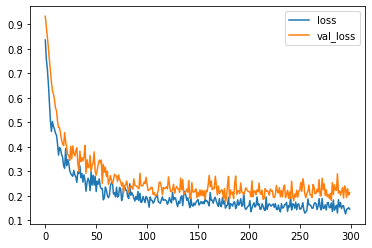

tf.Tensor([[-1.439222]], shape=(1, 1), dtype=float32)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 38)                228       
_________________________________________________________________
dense_1 (Dense)              (None, 41)                1599      
_________________________________________________________________
dense_2 (Dense)              (None, 19)                798       
_________________________________________________________________
dense_3 (Dense)              (None, 35)                700       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
de

{'activation': 'relu',
 'drop_rate': 0.4,
 'num_layers': 4,
 'optimizer': 'rmsprop',
 'units_0': 38,
 'units_1': 41,
 'units_2': 19,
 'units_3': 35}

In [ ]:
# Train a DNN model for prediction

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt

# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test = x[110:119,:]
x = x [0:110,:]


y = data.loc[0:119, ['target']]
y=np.array(y)
y_target= y[110:119,:]
y_mean = np.mean(y,axis=0)
y_std = np.std(y,axis=0)
y = (y-y_mean)/y_std
y = y [0:110,:]



np.random.seed(3)
np.random.shuffle(x)
np.random.seed(3)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


#Define model
def model_builder(hp):
  model = keras.Sequential()
#Set the input layer
  model.add(keras.layers.Flatten(input_shape=(5,1)))
#Set dropout rate search space
  drop_rate = hp.Choice('drop_rate', 
                            [0.0, 0.1, 0.2, 0.3, 0.4,])
#Set activation function search space
  activation = hp.Choice('activation', 
                            ['relu', 'tanh', 'sigmoid'])
#In here, we tuner the number of layers using for loop
  for i in range(hp.Int('num_layers', 2 , 5)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                      min_value=5,
                      max_value=50,
                      step=1),
                activation= activation))
  model.add(keras.layers.Dropout(rate=drop_rate))
  model.add(keras.layers.Dense(1, activation='linear'))
#  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
  model.compile(
          optimizer= optimizer,
          loss='mean_absolute_error',
          metrics=['mean_absolute_error'])

#          optimizer=tf.keras.optimizers.optimizer(lr=hp_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08),

  return model
tuner = kt.RandomSearch(model_builder,
                     objective='val_mean_absolute_error',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='25524511215752482452452654245298')
# represent the search space
tuner.search_space_summary()

# search the best hyperparameters
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early])

# recall the overall hyperparameters
tuner.results_summary()

# train model with the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)


# plot the figure illustrating the training loss and validation loss
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
x = np.array([10,10,65,50,5])
x=x.reshape(1,5)
y=model(x)
print(y)
#manifest the model structure
model.summary()

#extract the best hyperparameters 
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [26]:
!pip3 install pygad

     |████████████████████████████████| 52 kB 1.1 MB/s 


/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


Generation = 1
Fitness    = [3.9200816]
Change     = [3.9200816]
Generation = 2
Fitness    = [3.9200816]
Change     = [0.]
Generation = 3
Fitness    = [3.9200816]
Change     = [0.]
Generation = 4
Fitness    = [4.045193]
Change     = [0.12511158]
Generation = 5
Fitness    = [4.045193]
Change     = [0.]
Generation = 6
Fitness    = [4.1764526]
Change     = [0.13125944]
Generation = 7
Fitness    = [4.1764526]
Change     = [0.]
Generation = 8
Fitness    = [4.1764526]
Change     = [0.]
Generation = 9
Fitness    = [4.1764526]
Change     = [0.]
Generation = 10
Fitness    = [4.1764526]
Change     = [0.]
Generation = 11
Fitness    = [4.1764526]
Change     = [0.]
Generation = 12
Fitness    = [4.1764526]
Change     = [0.]
Generation = 13
Fitness    = [4.250348]
Change     = [0.07389545]
Generation = 14
Fitness    = [4.250348]
Change     = [0.]
Generation = 15
Fitness    = [4.250348]
Change     = [0.]
Generation = 16
Fitness    = [4.250348]
Change     = [0.]
Generation = 17
Fitness    = [4.5567737]

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3105: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


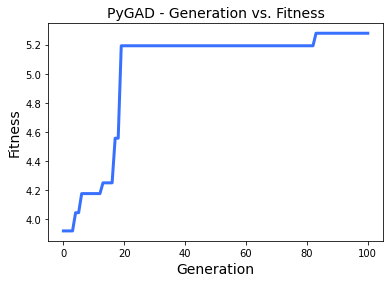

Parameters of the best solution : [11.62348231  8.10222253 79.02534538 69.614333    4.28675371]
Fitness value of the best solution = [0.18947107]


In [91]:
# Optimization for input features

import numpy as np
import pygad

#initialization
function_inputs = [0.5,0.5,0.5,0.5,0.5]

#define fitness function
def fitness_func(solution, solution_idx):
    target = [1.5]
    target = abs(y-y_mean)/y_std
    output=model(np.array(solution*function_inputs).reshape(1,5)) # model is built in keras.tuner
    output = abs(tf.subtract(abs(output), abs(target)))
    fitness =((1/output)).numpy()[0]
    #fitness =output.numpy()[0]
    return fitness

# Number of generations.
num_generations = 100
# Number of solutions to be selected as parents in the mating pool.
num_parents_mating = 5 
# Number of solutions in the population.
sol_per_pop = 10 
  
# Type of parent selection.
parent_selection_type = "sss"
# Type of the crossover operator.
crossover_type = "single_point" 
# Type of the mutation operator.
mutation_type = "random"

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(
     #Number of generations(iterations).
     num_generations=num_generations,
     num_parents_mating=num_parents_mating,
     fitness_func=fitness_func,
     sol_per_pop=sol_per_pop,
     #the Number of parameters(the number of genes)
     num_genes=5,
     gene_space=[np.arange(-1.68,2.88,0.01).tolist(),np.arange(-1.34,1.73,0.01).tolist(),np.arange(-0.88,1.56,0.01).tolist(),np.arange(-0.99,1.32,0.01).tolist(),
                 np.arange(-1.26,-0.392,0.01).tolist()],
     
     parent_selection_type=parent_selection_type,
     keep_parents=1,
     crossover_type=crossover_type,
     mutation_percent_genes=50,
     mutation_type=mutation_type,
     callback_generation=callback_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()


# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
solution = tf.multiply(solution,x_std)
solution = tf.add(solution, x_mean)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))

In [79]:
new=[5]
mean1=tf.divide((new-x_mean[4]),x_std[4])
print(mean1)

tf.Tensor([-0.39195853], shape=(1,), dtype=float64)


In [57]:
print(x_mean[0])
print(x_std[0])
print(new-x_mean[0])

10.109243697478991
0.6583646146487695
[-1.1092437]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/300
7/7 [==============================] - 1s 32ms/step - loss: 0.8240 - mae: 0.8240 - val_loss: 0.9711 - val_mae: 0.9711
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7710 - mae: 0.7710 - val_loss: 0.9431 - val_mae: 0.9431
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6906 - mae: 0.6906 - val_loss: 0.9131 - val_mae: 0.9131
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6271 - mae: 0.6271 - val_loss: 0.8747 - val_mae: 0.8747
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5830 - mae: 0.5830 - val_loss: 0.8248 - val_mae: 0.8248
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5727 - mae: 0.5727 - val_loss: 0.8028 - val_mae: 0.8028
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5542 - mae: 0.5542 - val_loss: 0.7886 - val_mae: 0.7886
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5212 - mae: 0.5212 - va

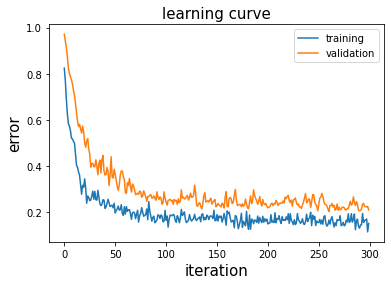

tf.Tensor(
[[2.5887327 ]
 [0.74105096]
 [0.6631665 ]
 [0.46016312]
 [0.16847605]
 [0.7316115 ]
 [0.1498766 ]
 [0.5800476 ]
 [0.35225797]], shape=(9, 1), dtype=float32)
tf.Tensor(
[[0.15801336]
 [0.20028403]
 [0.13718794]
 [0.10080244]
 [0.26242372]
 [0.27016672]
 [0.09001598]
 [0.19360735]
 [0.12231179]], shape=(9, 1), dtype=float32)


In [ ]:
#group 1
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test = x[110:119,:]
x = x [0:110,:]


y = data.loc[0:119, ['target']]
y=np.array(y)
y_target= y[110:119,:]
y_mean = np.mean(y,axis=0)
y_std = np.std(y,axis=0)
y = (y-y_mean)/y_std
y = y [0:110,:]



np.random.seed(3)
np.random.shuffle(x)
np.random.seed(3)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(5,1)),
        tf.keras.layers.Dense(38, activation=tf.nn.relu),
        tf.keras.layers.Dense(41, activation=tf.nn.relu),
        tf.keras.layers.Dense(19, activation=tf.nn.relu),
        tf.keras.layers.Dense(35, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='linear')
])
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
#Adagrad(lr=0.01, epsilon=1e-06)
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss='mae',
          metrics=['mae'])

history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)
#history=model.fit(x_train, y_train, batch_size=16, epochs=200, validation_split=0.2, validation_freq=1,shuffle=False)

model.summary()



epochs = len(history.history['loss'])
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],label='training')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],label='validation')
plt.legend(fontsize=10)
plt.title('learning curve',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('error',fontsize=15)
plt.show()
y_test=model(x_test)
y_mid= tf.multiply(y_test,y_std)
y_test= tf.add(y_mid, y_mean)
error= tf.abs(tf.subtract(y_test, y_target))
error_percentage = tf.divide(error, y_target)
print(error)
print(error_percentage)

In [24]:
print(y_test)

tf.Tensor(
[[14.460794 ]
 [ 3.43695  ]
 [ 3.9952166]
 [ 3.7577956]
 [ 0.727005 ]
 [ 2.614872 ]
 [ 1.5745175]
 [ 3.0763388]
 [ 2.815491 ]], shape=(9, 1), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/300
7/7 [==============================] - 1s 25ms/step - loss: 0.7939 - mae: 0.7939 - val_loss: 0.9934 - val_mae: 0.9934
Epoch 2/300
7/7 [==============================] - 0s 5ms/step - loss: 0.7591 - mae: 0.7591 - val_loss: 0.9769 - val_mae: 0.9769
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6942 - mae: 0.6942 - val_loss: 0.9495 - val_mae: 0.9495
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6646 - mae: 0.6646 - val_loss: 0.9126 - val_mae: 0.9126
Epoch 5/300
7/7 [==============================] - 0s 5ms/step - loss: 0.6076 - mae: 0.6076 - val_loss: 0.8671 - val_mae: 0.8671
Epoch 6/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5670 - mae: 0.5670 - val_loss: 0.8346 - val_mae: 0.8346
Epoch 7/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5564 - mae: 0.5564 - val_loss: 0.8243 - val_mae: 0.8243
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5251 - mae: 0.5251 - va

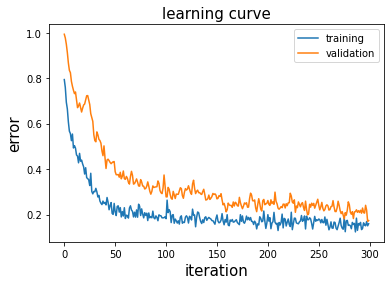

tf.Tensor(
[[1.922205  ]
 [0.26305008]
 [0.8387835 ]
 [0.8072045 ]
 [0.08500499]
 [0.09312797]
 [0.09048247]
 [0.08033872]
 [0.06450915]], shape=(9, 1), dtype=float32)
tf.Tensor(
[[0.11732925]
 [0.07109462]
 [0.17351748]
 [0.17682464]
 [0.13240652]
 [0.03438994]
 [0.05434383]
 [0.02681533]
 [0.02239901]], shape=(9, 1), dtype=float32)


In [23]:
#group 2
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test = x[110:119,:]
x = x [0:110,:]


y = data.loc[0:119, ['target']]
y=np.array(y)
y_target= y[110:119,:]
y_mean = np.mean(y,axis=0)
y_std = np.std(y,axis=0)
y = (y-y_mean)/y_std
y = y [0:110,:]



np.random.seed(3)
np.random.shuffle(x)
np.random.seed(3)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(5,1)),
        tf.keras.layers.Dense(38, activation=tf.nn.relu),
        tf.keras.layers.Dense(41, activation=tf.nn.relu),
        tf.keras.layers.Dense(19, activation=tf.nn.relu),
        tf.keras.layers.Dense(35, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='linear')
])
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
#Adagrad(lr=0.01, epsilon=1e-06)
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss='mae',
          metrics=['mae'])

history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)
#history=model.fit(x_train, y_train, batch_size=16, epochs=200, validation_split=0.2, validation_freq=1,shuffle=False)

model.summary()



epochs = len(history.history['loss'])
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],label='training')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],label='validation')
plt.legend(fontsize=10)
plt.title('learning curve',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('error',fontsize=15)
plt.show()
y_test=model(x_test)
y_mid= tf.multiply(y_test,y_std)
y_test= tf.add(y_mid, y_mean)
error= tf.abs(tf.subtract(y_test, y_target))
error_percentage = tf.divide(error, y_target)
print(error)
print(error_percentage)
save_path = r'E:\model\test.h5'
model.save(save_path)

In [25]:
print(y_test)

tf.Tensor(
[[14.460794 ]
 [ 3.43695  ]
 [ 3.9952166]
 [ 3.7577956]
 [ 0.727005 ]
 [ 2.614872 ]
 [ 1.5745175]
 [ 3.0763388]
 [ 2.815491 ]], shape=(9, 1), dtype=float32)


In [ ]:
print(y_std)
y_test=model(x_test)
print(y_test)
y_mid= tf.multiply(y_test,y_std)
print(y_mid)
y_test= tf.add(y_mid, y_mean)
print(y_test)


In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
model.compiled_metrics_dict.keys()

In [ ]:
x = np.array([10,10,65,50,5],[10,10,80,50,6],[11,8,50,60,5],[10,10,50,60,20],[11,8,50,60,13])

In [ ]:
test = pd.read_csv('/content/test.csv')
x_test = test.loc[0:7, ['A','B','C','D','E']]
y_target = test.loc[0:7, ['target']]
y_target = np.array(y_target)
x_test = np.array(x_test)
y_test=model(x_test)
error= tf.abs(tf.subtract(y_test, y_target))
error_percentage = tf.divide(error, y_target)
print(error)
print(error_percentage)

In [ ]:
print(x_train)

In [ ]:

x_train = data.loc[0:80, ['A','B','C','D','E']]
x_train=np.array(x_train)
y_train = data.loc[0:80, ['target']]
y_train=np.array(y_train)

x_val = data.loc[80:103, ['A','B','C','D','E']]
x_val = np.array(x_val)
y_val = data.loc[80:103, ['target']]
y_val = np.array(y_val)

np.random.seed(116)
np.random.shuffle(x_train)
np.random.seed(116)
np.random.shuffle(y_train)
tf.random.set_seed(116)

In [ ]:
test = pd.read_csv('/content/test.csv')

x = data.loc[0:98, ['A','B','C','D','E']]
x=np.array(x)
y = data.loc[0:98, ['target']]
y=np.array(y)


np.random.seed(116)
np.random.shuffle(x)
np.random.seed(116)
np.random.shuffle(y)

x_train = x[0:80,:]
x_val = x[81:95,:]
y_train = y[0:80,:]
y_val = y[81:95,:]



In [ ]:
data = pd.read_csv('/content/traincmp.csv')

x = data.loc[0:98, ['A','B','C','D','E']]
x=np.array(x)
y = data.loc[0:98, ['target']]
y=np.array()

np.random.seed(116)
np.random.shuffle(x)
np.random.seed(116)
np.random.shuffle(y)

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/traincmp.csv')

x = data.loc[0:120, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std



In [ ]:
# Train a DNN model for prediction

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt

# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
a=x.shape
print(a)
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std

x_test= x[110:118,:]
print(x_test)

(119, 5)
[[-0.16593191 -0.31837456 -0.88224852  1.32470325 -1.1661173 ]
 [-1.68484708 -1.34233596 -0.88224852 -0.99352744 -1.06934745]
 [-1.68484708 -1.34233596  0.33853722  1.32470325  0.47897007]
 [-0.16593191 -0.31837456 -0.88224852  1.32470325  1.54343837]
 [ 1.35298326 -1.34233596  1.55932296 -0.99352744 -0.68226807]
 [-0.16593191  1.72954826 -0.88224852  0.16558791 -0.19841884]
 [-0.16593191  0.70558685 -0.88224852  1.32470325  0.57573992]
 [-0.16593191 -0.31837456  1.55932296 -0.99352744  1.54343837]]


In [ ]:
# Train a DNN model for prediction

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt

# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std

y = data.loc[0:119, ['target']]
y=np.array(y)



np.random.seed(5)
np.random.shuffle(x)
np.random.seed(5)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


#Define model
def model_builder(hp):
  model = keras.Sequential()
#Set the input layer
  model.add(keras.layers.Flatten(input_shape=(5,1)))
#Set dropout rate search space
  drop_rate = hp.Choice('drop_rate', 
                            [0.0, 0.1, 0.2, 0.3, 0.4,])
#Set activation function search space
  activation = hp.Choice('activation', 
                            ['relu', 'tanh', 'sigmoid'])
#In here, we tuner the number of layers using for loop
  for i in range(hp.Int('num_layers', 2 , 5)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                      min_value=5,
                      max_value=50,
                      step=1),
                activation= activation))
  model.add(keras.layers.Dropout(rate=drop_rate))
  model.add(keras.layers.Dense(1, activation='linear'))
#  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
  model.compile(
          optimizer= optimizer,
          loss='mean_absolute_error',
          metrics=['mean_absolute_error'])

#          optimizer=tf.keras.optimizers.optimizer(lr=hp_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08),

  return model
tuner = kt.RandomSearch(model_builder,
                     objective='val_mean_absolute_error',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='254362112455424535462124698')
# represent the search space
tuner.search_space_summary()

# search the best hyperparameters
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early])

# recall the overall hyperparameters
tuner.results_summary()

# train model with the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)


# plot the figure illustrating the training loss and validation loss
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
x = np.array([10,10,65,50,5])
x=x.reshape(1,5)
y=model(x)
print(y)

#manifest the model structure
model.summary()

#extract the best hyperparameters 
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [ ]:
x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test=x[110:119,:]
y = data.loc[0:119, ['target']]
y=np.array(y)
y_test=model(x_test)
y_target=y[110:119,:]
error= tf.abs(tf.subtract(y_test, y_target))
error_percentage = tf.divide(error, y_target)
print(error)
print(error_percentage)